In [208]:
import darts
import datetime
from darts.datasets import AirPassengersDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

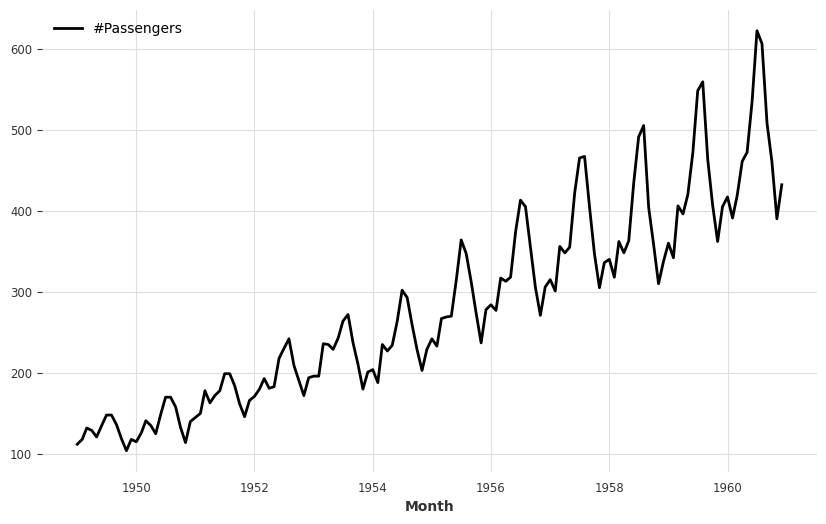

In [181]:
fig, ax = plt.subplots(figsize=(10, 6))
series = AirPassengersDataset().load()
series.plot(ax=ax);

In [185]:
df = series.to_dataframe()
df.columns = ["n_passengers"]
df["date_idx"] = df.index.to_series().dt.year * 12 + df.index.to_series().dt.month
df["n_months"] = df.date_idx - df.date_idx.min() + 1  # might want to log this later
df["n_months"] = df["n_months"].astype(int)
df = df.drop(columns=["date_idx"])
df.head()

,n_passengers,n_months
Month,,
1949-01-01,112.0,1
1949-02-01,118.0,2
1949-03-01,132.0,3
1949-04-01,129.0,4
1949-05-01,121.0,5


In [191]:
def get_80pct_of_data_points(df):
    """Returns a dataframe with 80% of the data points."""
    return df.iloc[: int(len(df) * 0.8)]


def get_other_20pct_of_data_points(df):
    """Returns a dataframe with the complement of the 80% of the data points."""
    return df.iloc[int(len(df) * 0.8) :]


print(f"n data points: {len(df)}")
print(f"Training set contains: {get_80pct_of_data_points(df).shape[0]}")
print(f"Testing set contains: {get_other_20pct_of_data_points(df).shape[0]}")

n data points: 144
Training set contains: 115
Testing set contains: 29


In [196]:
X, y = df.n_months, df.n_passengers

X_train, y_train = (
    get_80pct_of_data_points(df).n_months,
    get_80pct_of_data_points(df).n_passengers,
)
X_test, y_test = (
    get_other_20pct_of_data_points(df).n_months,
    get_other_20pct_of_data_points(df).n_passengers,
)
X_train = X_train.values.reshape(-1, 1)
X_test = X_test.values.reshape(-1, 1)
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((115, 1), (115,), (29, 1), (29,))

In [207]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
yhat_train = lr.predict(X_train)
yhat_test = lr.predict(X_test)

mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)
yhat_train.shape, yhat_test.shape

((115,), (29,))

In [201]:
train_dates = df.index.to_numpy()[: int(len(df) * 0.8)]
test_dates = df.index.to_numpy()[int(len(df) * 0.8) :]
train_dates.shape, test_dates.shape

((115,), (29,))

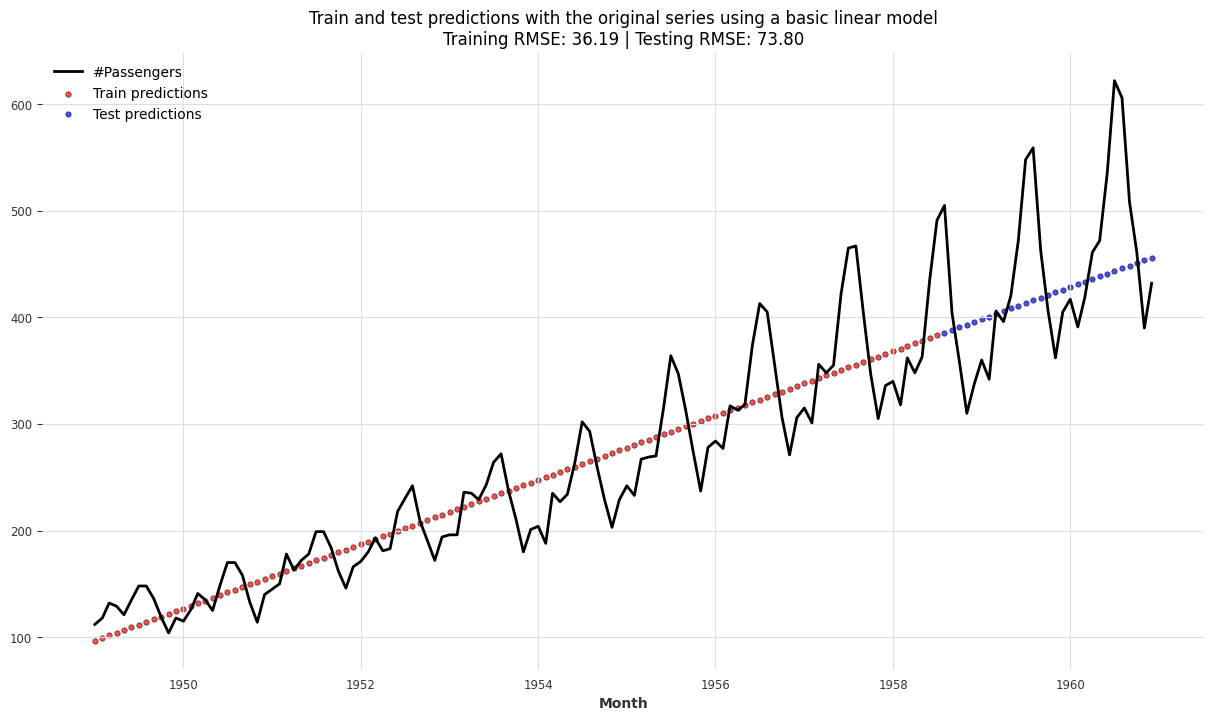

In [212]:
fig, ax = plt.subplots(figsize=(15, 8))
series.plot(ax=ax)

ax.scatter(
    train_dates,
    yhat_train,
    color="red",
    label="Train predictions",
    s=15,
    marker="o",
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5,
)

ax.scatter(
    test_dates,
    yhat_test,
    color="blue",
    label="Test predictions",
    s=15,
    marker="o",
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5,
)

ax.set_title(
    "Train and test predictions with the original series using a basic linear model\n"
    f"Training RMSE: {np.sqrt(mse_train):.2f} | Testing RMSE: {np.sqrt(mse_test):.2f}",
)
plt.legend()
plt.show()

### Log-linear model

In [213]:
lr = LinearRegression()
lr.fit(X_train, np.log(y_train))
yhat_train = np.exp(lr.predict(X_train))
yhat_test = np.exp(lr.predict(X_test))

mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)
yhat_train.shape, yhat_test.shape

((115,), (29,))

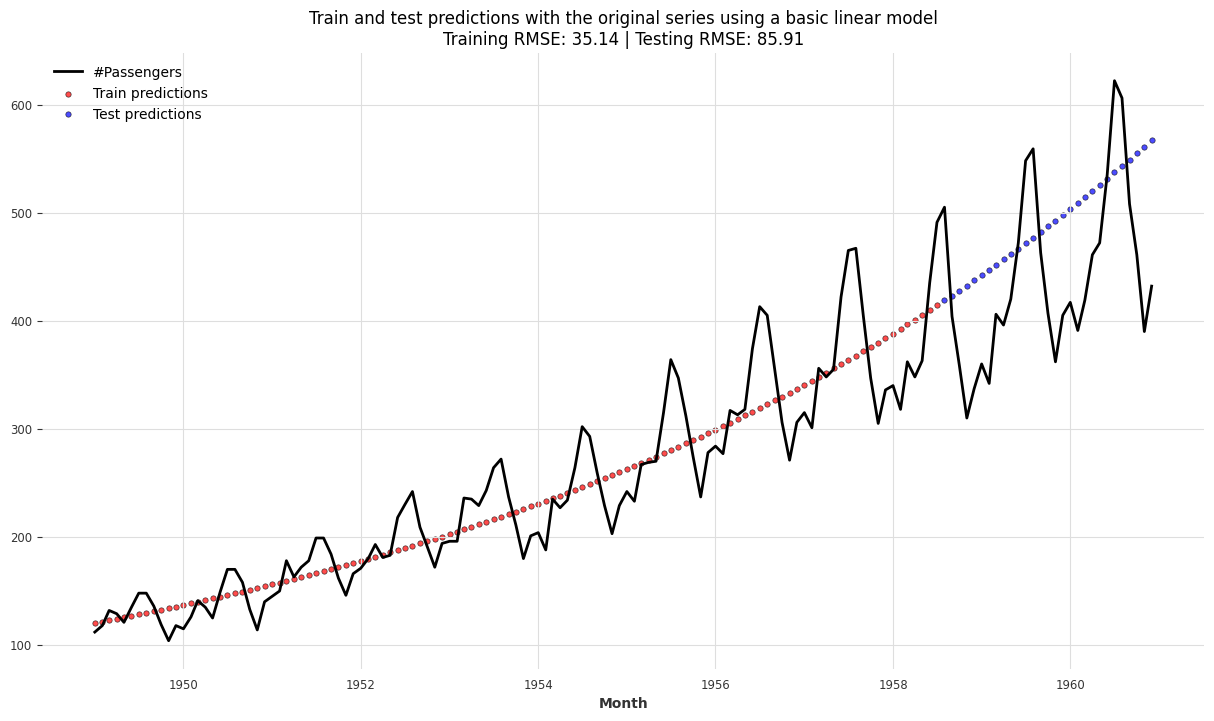

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
series.plot(ax=ax)

ax.scatter(
    train_dates,
    yhat_train,
    color="red",
    label="Train predictions",
    s=15,
    marker="o",
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5,
)

ax.scatter(
    test_dates,
    yhat_test,
    color="blue",
    label="Test predictions",
    s=15,
    marker="o",
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5,
)

ax.set_title(
    "Train and test predictions with the original series using a log-linear model\n"
    f"Training RMSE: {np.sqrt(mse_train):.2f} | Testing RMSE: {np.sqrt(mse_test):.2f}",
)
plt.legend()
plt.show()

### Fourier features

In [220]:
twopi = 2 * np.pi

fourier_train = np.hstack(
    [
        np.sin(twopi * X_train / 12),
        np.cos(twopi * X_train / 12),
    ]
)
fourier_test = np.hstack(
    [
        np.sin(twopi * X_test / 12),
        np.cos(twopi * X_test / 12),
    ]
)

fourier_train[:5], fourier_test[:5]

(array([[ 5.00000000e-01,  8.66025404e-01],
        [ 8.66025404e-01,  5.00000000e-01],
        [ 1.00000000e+00,  6.12323400e-17],
        [ 8.66025404e-01, -5.00000000e-01],
        [ 5.00000000e-01, -8.66025404e-01]]),
 array([[-8.66025404e-01, -5.00000000e-01],
        [-1.00000000e+00, -4.16441810e-15],
        [-8.66025404e-01,  5.00000000e-01],
        [-5.00000000e-01,  8.66025404e-01],
        [-9.55472096e-15,  1.00000000e+00]]))

In [221]:
lr = LinearRegression()
xtrain = np.hstack(
    [
        X_train,
        fourier_train,
    ]
)
xtest = np.hstack(
    [
        X_test,
        fourier_test,
    ]
)
lr.fit(xtrain, np.log(y_train))

yhat_train = np.exp(lr.predict(xtrain))
yhat_test = np.exp(lr.predict(xtest))

mse_train = mean_squared_error(y_train, yhat_train)
mse_test = mean_squared_error(y_test, yhat_test)
yhat_train.shape, yhat_test.shape

((115,), (29,))

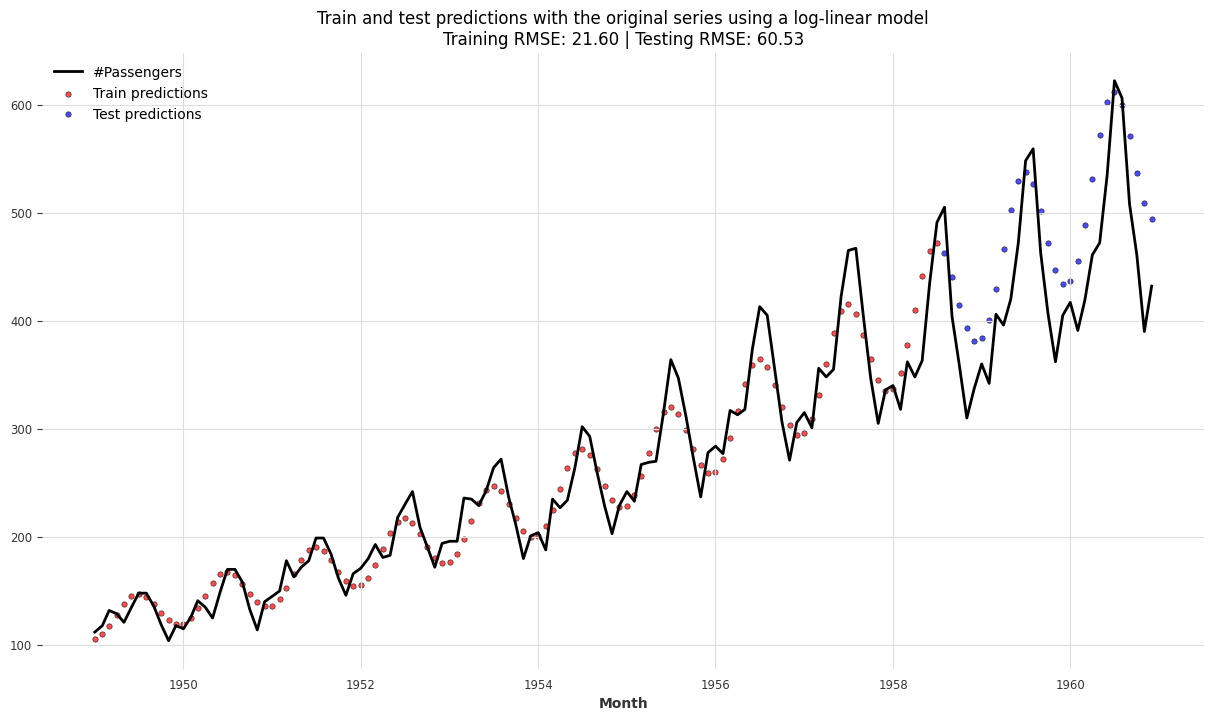

In [222]:
fig, ax = plt.subplots(figsize=(15, 8))
series.plot(ax=ax)

ax.scatter(
    train_dates,
    yhat_train,
    color="red",
    label="Train predictions",
    s=15,
    marker="o",
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5,
)

ax.scatter(
    test_dates,
    yhat_test,
    color="blue",
    label="Test predictions",
    s=15,
    marker="o",
    alpha=0.7,
    edgecolors="black",
    linewidth=0.5,
)

ax.set_title(
    "Train and test predictions with the original series using a log-linear model\n"
    f"Training RMSE: {np.sqrt(mse_train):.2f} | Testing RMSE: {np.sqrt(mse_test):.2f}",
)
plt.legend()
plt.show()

/Users/andy/dev/fourier-features/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


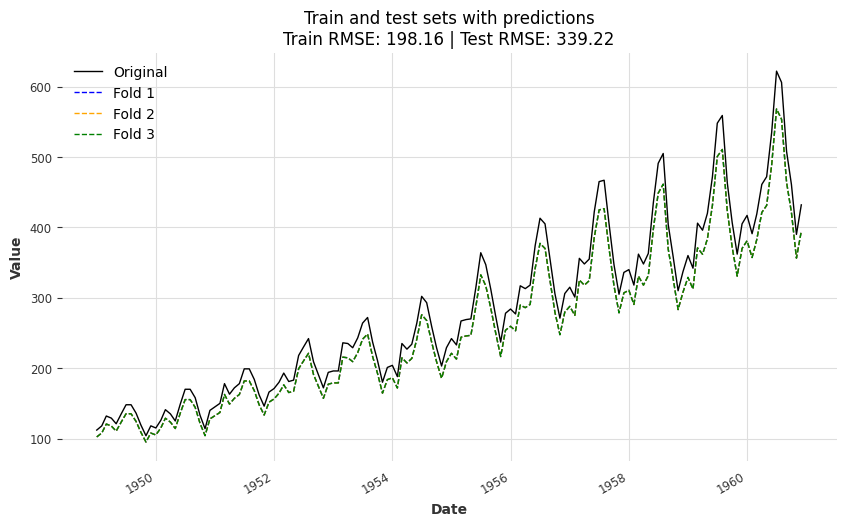

In [ ]:
%run src/fourier_features/_fit.py

X_transforms = [
    lambda x: np.log(x),
    lambda x: np.sin(x * 2 * np.pi / 1),
    lambda x: np.cos(x * 2 * np.pi / 1),
]

X0 = prep_X(X_duration, X_transforms)
y0 = prep_y(y)
# print(X0[:10], y0[:10])

ts = fit_ts_model(X0, y0)
plot_ts_model(ts, series, X_transforms=X_transforms)

/Users/andy/dev/fourier-features/.venv/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


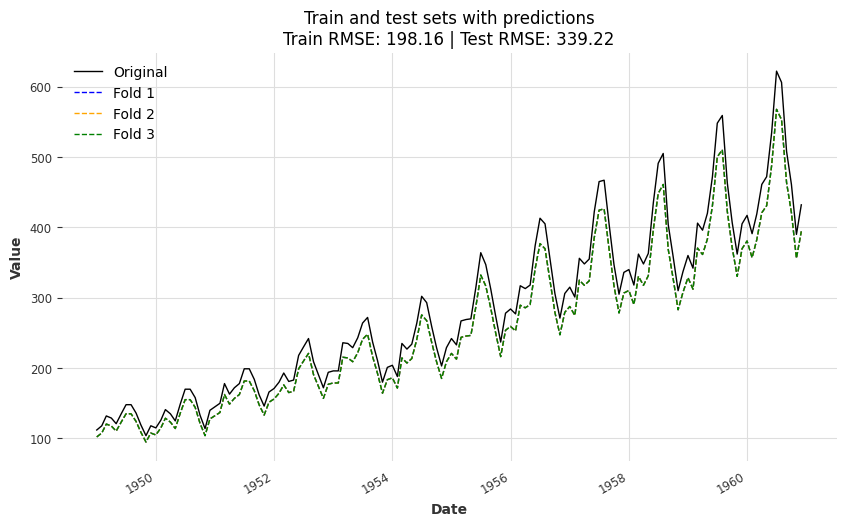

In [168]:
X_transforms = X_transforms + [
    lambda x: np.sin(x * 2 * np.pi / (2**1)),
    lambda x: np.cos(x * 2 * np.pi / (2**1)),
]

X0 = prep_X(X_duration, X_transforms)
y0 = prep_y(y)

ts = fit_ts_model(X0, y0)
plot_ts_model(ts, series, X_transforms=X_transforms)

In [163]:
series.shape

(144, 1, 1)

In [79]:
df_pred.head()

,#Passengers
Month,
1952-01-01,176.798862
1952-02-01,178.500915
1952-03-01,180.202968
1952-04-01,181.905020
1952-05-01,183.607073


In [6]:
series.to_dataframe()


component,#Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0
